# Introduction

This code should run on a Raspberry Pi that is connected to the high quality cam.
It will create images in the data folder.

In [2]:
import cv2
from datetime import datetime
from io import BytesIO
import ipywidgets
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
from picamera import PiCamera
import requests
from time import sleep

from motor_control import MotorControl

In [3]:
img=cv2.imread('gerald-way-umbrella-academy-1.jpg')

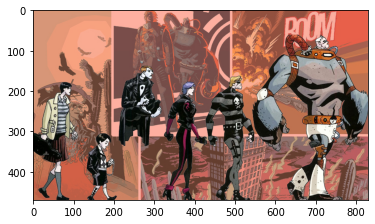

In [4]:
img_clr = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
plt.imshow(img_clr)

In [5]:
camera = PiCamera()
camera.resolution = (640,480)
camera.start_preview()

In [6]:
# Using video capture greatly speeds up the responsiveness (quality is less of course)
# It is possible to capture even faster using capture_sequence
# Documentation is on the following URL, since it complicates the code, it's probably best to leave this as a last resort
# https://picamera.readthedocs.io/en/release-1.13/recipes2.html#rapid-capture-and-processing
stream = BytesIO()
camera.capture(stream, format='jpeg', use_video_port=True)

In [7]:
# this code shows the more general stream capturing, however it's much easier to cirectly capture to an array
# See the update_image function below
stream.seek(0)
cam_img = cv2.imdecode(np.frombuffer(stream.read(), np.uint8), 1)
cam_img_clr = cv2.cvtColor(cam_img, cv2.COLOR_BGR2RGBA)

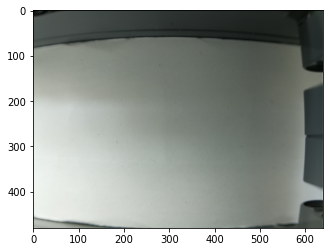

In [8]:
plt.imshow(cam_img_clr)

In [9]:
def bytes_to_jpg(img):
    return bytes(cv2.imencode('.jpg', img)[1])

In [10]:
image_widget = ipywidgets.Image(format='jpeg')
image_widget.value = bytes_to_jpg(cam_img_clr)
display(image_widget)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x02\x01\x0…

In [11]:
processed_widget = ipywidgets.Image(format='jpeg')
display(processed_widget)

Image(value=b'', format='jpeg')

In [12]:
motor_control = MotorControl('192.168.50.222', 80)

In [18]:
def write_image(image_bytes, prefix = ''):
    filename = "data/new/" + prefix + datetime.now().strftime("%Y%m%d%H%M%S") + ".jpg"
    with open(filename, "wb") as file:
       file.write(image_bytes)
    return filename

In [14]:
top_border = 100
bottom_border = 40

def take_picture():
    cam_img = np.empty((640*480*3,), dtype=np.uint8)
    camera.capture(cam_img, format='bgr', use_video_port=True)
    return cam_img.reshape((480,640,3))
    
def pre_process_image(image):
    without_borders = image[top_border:480-bottom_border,:]
    gray = cv2.cvtColor(without_borders, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    return gray
    
first_picture = take_picture()
write_image(bytes_to_jpg(first_picture), 'reference')
first_image = pre_process_image(first_picture)

In [15]:
def update_image():
    cam_img = take_picture()
    gray = pre_process_image(cam_img)
    
    image_diff = cv2.absdiff(first_image, gray)
    thresh = cv2.threshold(image_diff, 50, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.dilate(thresh, None, iterations=2)
    #thresh = cv.Canny(thresh, 40, 80)
    # Find contours
    #_, contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    left_most_contour_x = 640
    for c in contours:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < 40:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        if w > 600 or w < 50:
            continue
        cv2.rectangle(cam_img, (x, y + top_border), (x + w, y + h + top_border), (0, 255, 0), 2)
        if x < left_most_contour_x:
            left_most_contour_x = x 

    image_widget.value = bytes_to_jpg(cam_img)
    processed_widget.value = bytes_to_jpg(thresh)
    return left_most_contour_x

In [26]:
predict_url = "http://192.168.50.17:5000/predict"
def predict(image_bytes):
    filename = write_image(image_bytes)
    payload={}
    files=[
      ('image',(filename[filename.rindex('/')+1:],open(filename,'rb'),'image/jpeg'))
    ]
    headers = {}
    return requests.request("POST", predict_url, headers=headers, data=payload, files=files)

In [39]:
import threading
from time import sleep
running = True
def update_image_loop():
    global running
    motor_control.on_all()
    while running:
        contour_x = update_image()
        if  contour_x < 640:
            motor_control.stop_all()
            sleep(0.5) # wait for brick to drop
            contour_x = update_image()
            motor_control.move_to_center(contour_x)
            sleep(0.5)
            print(predict(bytes_to_jpg(take_picture())).text)
            motor_control.clear_camera_belt()
            sleep(0.5)
            motor_control.on_all()
    motor_control.stop_all()
        
t = threading.Thread(target=update_image_loop)
t.start()

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"43857liftarmthick1x2"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoclip"}

{"prediction":"15712tile1x1withopenoc

In [40]:
running = False
t.join()

In [19]:
camera.stop_preview()
camera.close()